## Будникова Валерия Павловна М8О-407Б-19
## Лабораторная работа 1

In [1]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import pickle
import pandas as pd
import os
import math
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV
import pickle
from IPython.display import display

Вспомогательные функции:

In [2]:
def Plot_box(data,names):
    plt.figure(figsize=(30, 20))
    l = len(names)
    a = l // 2 + 1
    b = (l // a + 1) * 2
    a, b = b, a
    ind = 1
    for n in range(l):
        plt.subplot(a, b, ind)
        sns.boxplot(x = data['Fire Alarm'] , y = data[names[n]])
        ind += 1
    
    plt.show()

def Plot_hist(data, names):
    colors = sns.color_palette("hls", len(names))
    plt.figure(figsize=(30, 10))
    plt.rc('legend', fontsize=10)  
    plt.rc('font', size=10)
    l = len(names)
    a = l // 2 + 1
    b = l // a + 1
    a, b = b, a
    for i in range(l):
        x = plt.subplot(a, b, i + 1)
        val = data[names[i]]
        x.hist(val, color=colors[i], label=names[i]);
        x.legend()

from sklearn import metrics
def plot_ConfusionMatrix(y_true, y_pred, title = ""):
    c_matr = metrics.confusion_matrix(y_true, y_pred) 
    disp = metrics.ConfusionMatrixDisplay(c_matr)
    fig, ax = plt.subplots(figsize=(10,10));
    disp.plot(ax=ax);
    disp.ax_.set_title("ConfusionMatrix " + title);

### Анализ и подготовка данных

In [3]:
file_path = "smoke_detection_iot.csv"

data = pd.read_csv(file_path, parse_dates=True)

names = [col for col in data.columns]
data = data.drop(columns=[names[0]])
names = names[1:]
colors = sns.color_palette("hls", len(names))

print(" len data: {}".format(len(data)))
print(" len data_without_miss: {}".format(len(data.dropna())))

print("Data shape: ", data.shape)
data.head()


 len data: 62630
 len data_without_miss: 62630
Data shape:  (62630, 15)


,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62630 non-null  int64  
 1   Temperature[C]  62630 non-null  float64
 2   Humidity[%]     62630 non-null  float64
 3   TVOC[ppb]       62630 non-null  int64  
 4   eCO2[ppm]       62630 non-null  int64  
 5   Raw H2          62630 non-null  int64  
 6   Raw Ethanol     62630 non-null  int64  
 7   Pressure[hPa]   62630 non-null  float64
 8   PM1.0           62630 non-null  float64
 9   PM2.5           62630 non-null  float64
 10  NC0.5           62630 non-null  float64
 11  NC1.0           62630 non-null  float64
 12  NC2.5           62630 non-null  float64
 13  CNT             62630 non-null  int64  
 14  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 7.2 MB


Анализируя матрицу корреляций, можно заметить, что некоторые данные сильно зависят друг от друга(например PM1.0 и NC2.5), а также присутствуют данные, очень слабо влияющие на результат. Если характеристики имеют сильную прямую или обратную связь, то нахождение этих характеристик вместе в одном датасете при расчетах излишне. 

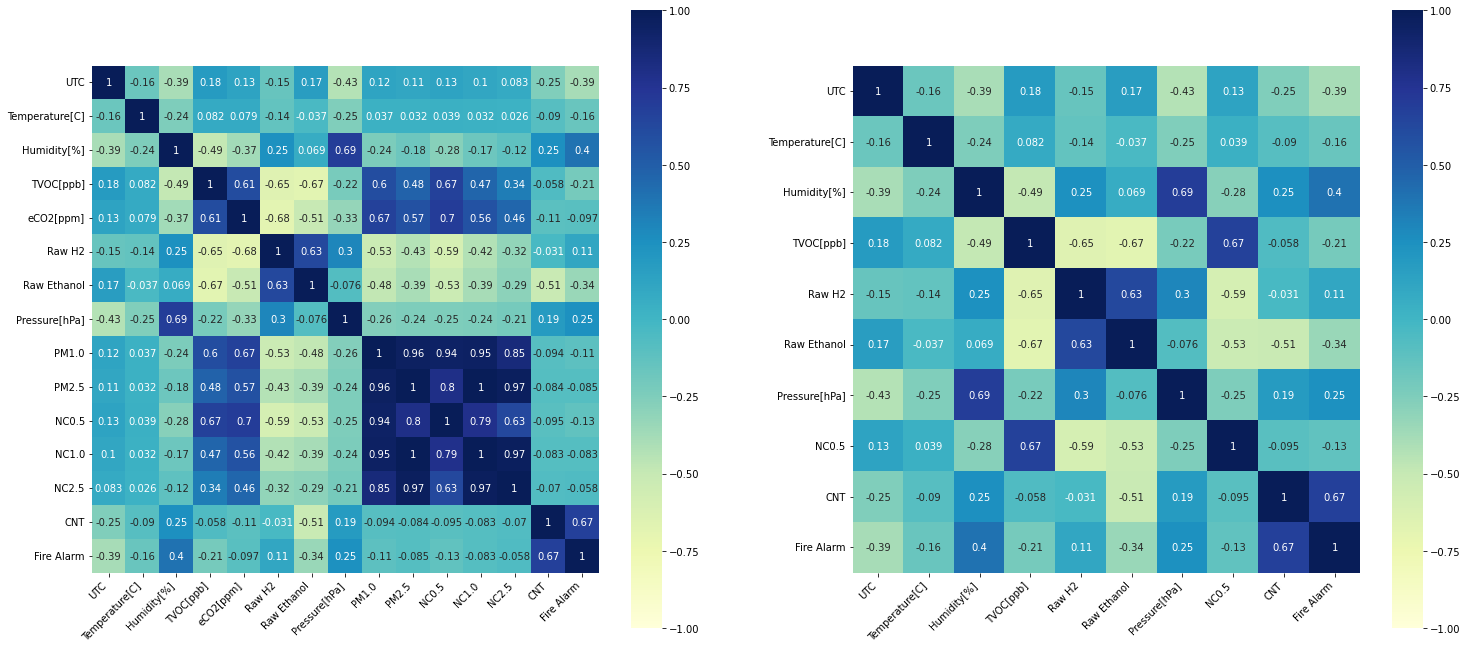

In [5]:
corr1 = data.corr()
plt.figure(figsize=(25, 25))
x1 = plt.subplot(2, 2, 1)
x1 = sns.heatmap(corr1, annot = True, vmin=-1, cmap="YlGnBu", vmax=1, square=True)
x1.set_xticklabels(x1.get_xticklabels(), rotation=45, horizontalalignment='right');


data1 = data.drop(columns=['PM2.5', 'PM1.0', 'NC2.5', 'NC1.0', 'eCO2[ppm]'])
corr2 = data1.corr()
x2 = plt.subplot(2, 2, 2)
x2 = sns.heatmap(corr2, annot = True, vmin=-1, cmap="YlGnBu", vmax=1, square=True)
x2.set_xticklabels(x2.get_xticklabels(), rotation=45, horizontalalignment='right');

plt.show()

In [6]:
data = data1
names = [col for col in data.columns]

Посмторим на гистограмму данных. Как видно из графика, из за того, что у данных раздая размерность, большинства характеристик не видно за графиками остальных.

<AxesSubplot:ylabel='Frequency'>

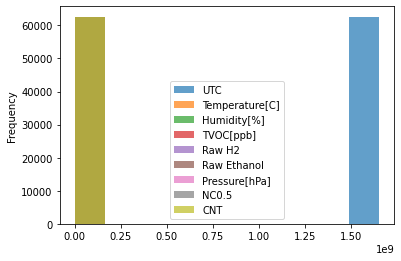

In [7]:
display(data[names[:-1]].plot.hist(alpha=0.7))

Нормализируем данные и посмотрим на результат

In [8]:
display(data.describe())
normalized_data=(data[names[:-1]] - data[names[:-1]].mean())/data[names[:-1]].std()
normalized_data[names[-1]] = data[names[-1]]
display(normalized_data.describe())

,UTC,Temperature[C],Humidity[%],TVOC[ppb],Raw H2,Raw Ethanol,Pressure[hPa],NC0.5,CNT,Fire Alarm
count,6.263000e+04,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,1.654792e+09,15.970424,48.539499,1942.057528,12942.453936,19754.257912,938.627649,491.463608,10511.386157,0.714626
std,1.100025e+05,14.359576,8.865367,7811.589055,272.464305,609.513156,1.331344,4265.661251,7597.870997,0.451596
min,1.654712e+09,-22.010000,10.740000,0.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000
25%,1.654743e+09,10.994250,47.530000,130.000000,12830.000000,19435.000000,938.700000,8.820000,3625.250000,0.000000
50%,1.654762e+09,20.130000,50.150000,981.000000,12924.000000,19501.000000,938.816000,12.450000,9336.000000,1.000000
75%,1.654778e+09,25.409500,53.240000,1189.000000,13109.000000,20078.000000,939.418000,14.420000,17164.750000,1.000000
max,1.655130e+09,59.930000,75.200000,60000.000000,13803.000000,21410.000000,939.861000,61482.030000,24993.000000,1.000000


,UTC,Temperature[C],Humidity[%],TVOC[ppb],Raw H2,Raw Ethanol,Pressure[hPa],NC0.5,CNT,Fire Alarm
count,6.263000e+04,6.263000e+04,6.263000e+04,62630.000000,6.263000e+04,6.263000e+04,6.263000e+04,6.263000e+04,6.263000e+04,62630.000000
mean,-4.850542e-13,-5.808684e-17,-2.468691e-16,0.000000,-3.557819e-16,1.510258e-15,-6.566717e-14,7.260855e-18,-1.016520e-16,0.714626
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.451596
min,-7.261580e-01,-2.644954e+00,-4.263726e+00,-0.248612,-8.347713e+00,-7.280003e+00,-5.840453e+00,-1.152139e-01,-1.383465e+00,0.000000
25%,-4.438257e-01,-3.465404e-01,-1.138700e-01,-0.231970,-4.127291e-01,-5.237917e-01,5.434400e-02,-1.131463e-01,-9.063244e-01,0.000000
50%,-2.740546e-01,2.896726e-01,1.816620e-01,-0.123030,-6.772974e-02,-4.155085e-01,1.414740e-01,-1.122953e-01,-1.546994e-01,1.000000
75%,-1.317192e-01,6.573367e-01,5.302094e-01,-0.096403,6.112583e-01,5.311486e-01,5.936488e-01,-1.118334e-01,8.756879e-01,1.000000
max,3.072520e+00,3.061342e+00,3.007264e+00,7.432283,3.158381e+00,2.716499e+00,9.263954e-01,1.429803e+01,1.906009e+00,1.000000


<AxesSubplot:ylabel='Frequency'>

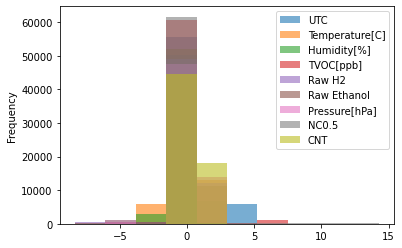

In [9]:
data_1 = normalized_data
data_1[names[:-1]].plot.hist(alpha=0.6)

Из графиков можно сделать вывод о том, что в некоторых характеристиках присутствуют выбросы  

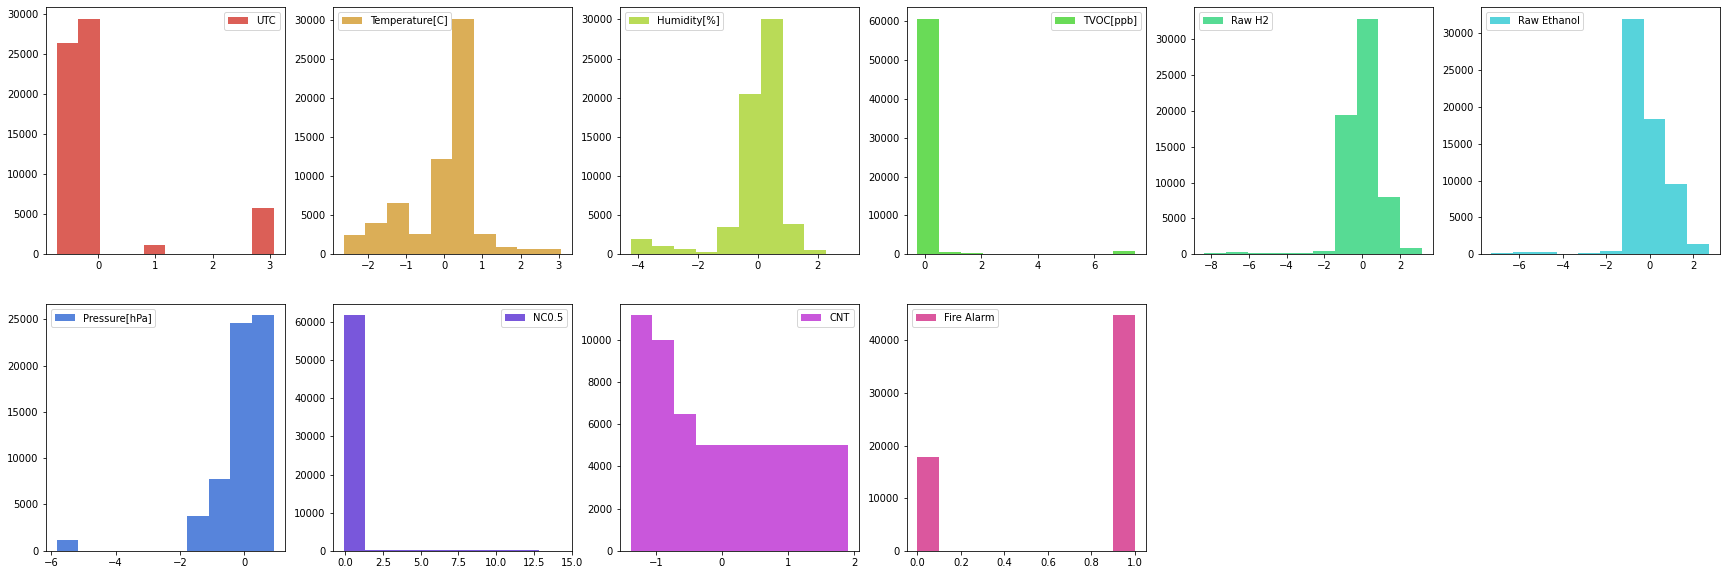

In [10]:
Plot_hist(data_1, names)

Посмотрим на выбросы:

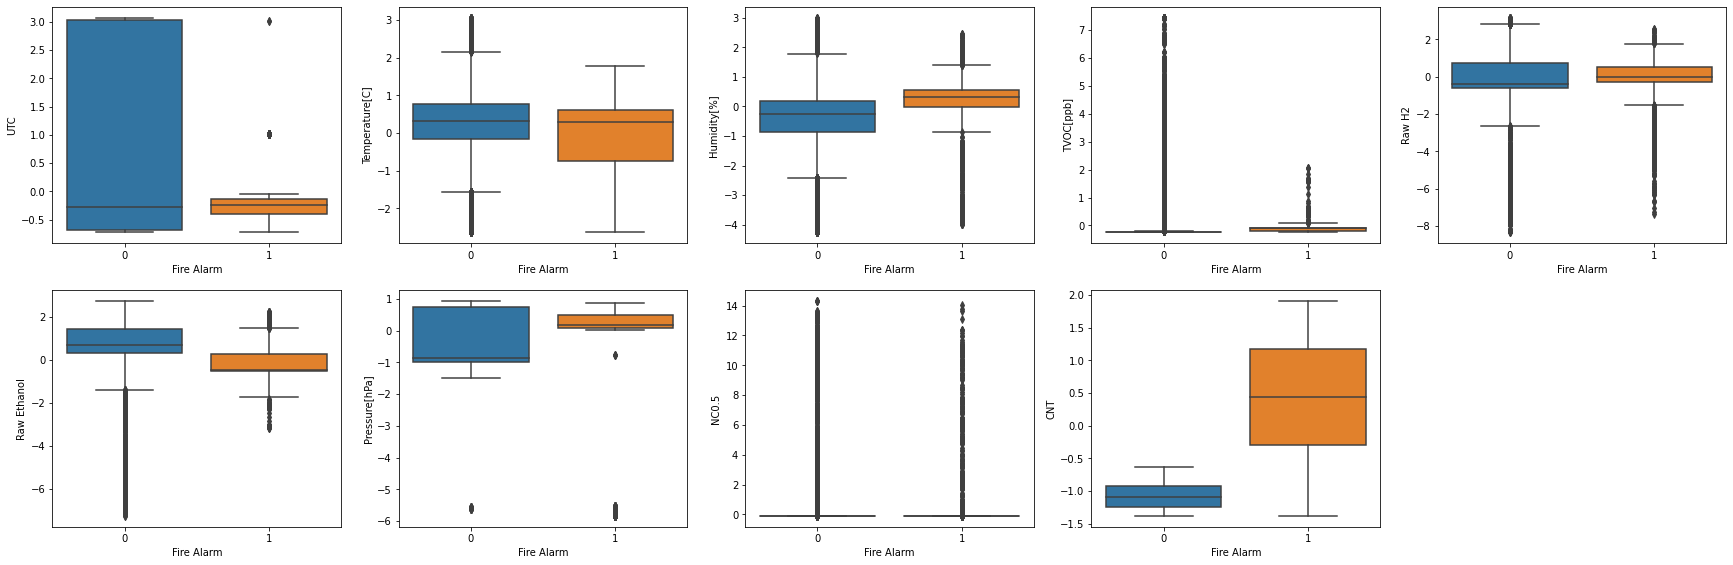

In [11]:
Plot_box(data_1, names[:-1])

Удалим выбросы

Fire Alarm
0    10207
1    41521
dtype: int64


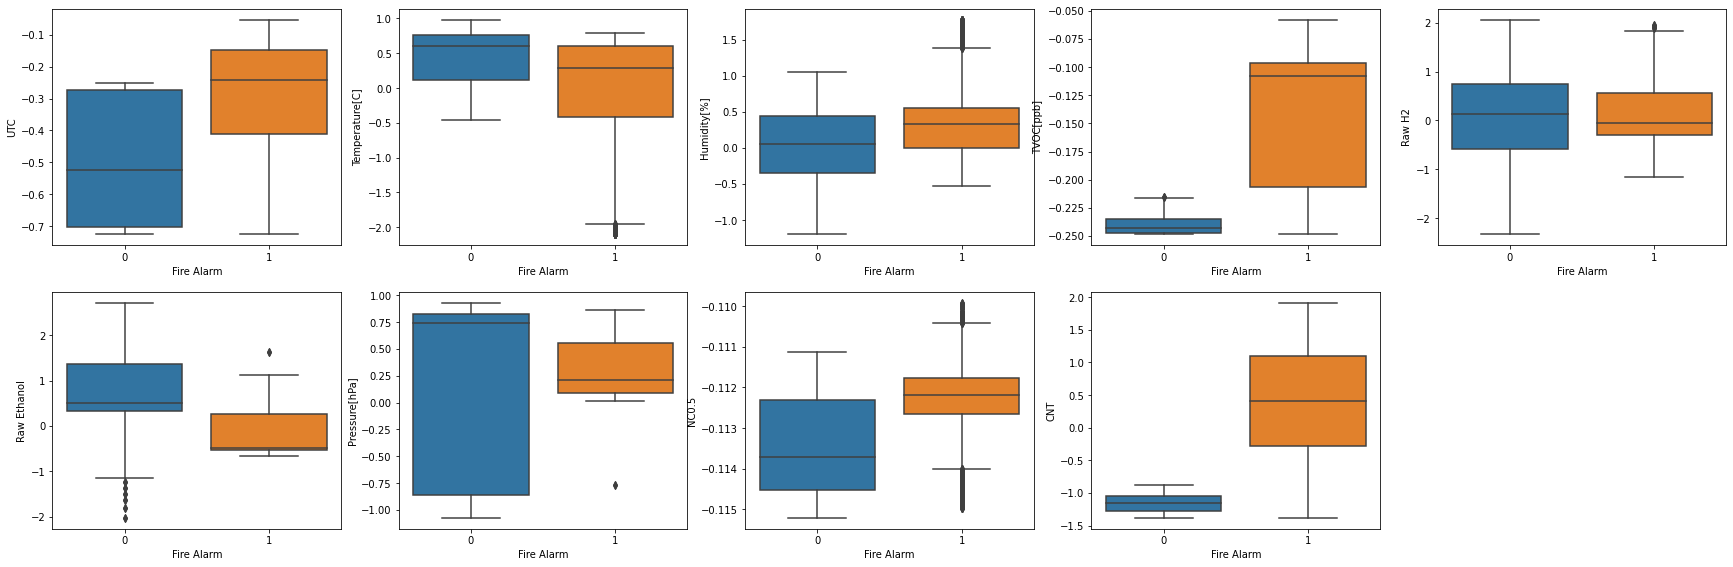

In [12]:
data_IQR = data_1
for i in range(0, len(names) - 2):
    qv1 = data[names[i]].quantile(0.25)
    qv2 = data[names[i]].quantile(0.85)
    between = qv2 - qv1
    data_IQR = data_IQR.loc[(data[names[i]] > (qv1 - 1.6 * between)) & (data[names[i]] < (qv2 + 1.6 * between))]

# data_IQR.drop_duplicates(keep="first", inplace=True)
print(data_IQR.groupby(names[-1]).size())
Plot_box(data_IQR, names[:-1])



In [13]:
data = data_IQR
data = data.reset_index(drop=True)
data.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],Raw H2,Raw Ethanol,Pressure[hPa],NC0.5,CNT,Fire Alarm
0,-0.533944,0.280619,0.994939,-0.248612,-2.335917,-2.024990,0.831754,-0.115214,-1.383465,0
1,-0.533935,0.281664,0.917108,-0.248612,-2.192779,-1.810064,0.838514,-0.115214,-1.383333,0
2,-0.533926,0.282639,0.837021,-0.248612,-2.086343,-1.624670,0.834008,-0.115214,-1.383201,0
3,-0.533917,0.283684,0.760318,-0.248612,-2.027619,-1.485215,0.832505,-0.115214,-1.383070,0
4,-0.533908,0.284728,0.693767,-0.248612,-1.979907,-1.367088,0.838514,-0.115214,-1.382938,0


После предварительного анализа данных была выявлена несбалансированность классов, что может привести к ошибкам (). Также была проведена нормализация данных, очистка от сильно зависящих друг от друга и мало влияющих на ответ характеристик и анализ выбросов.

### Дерево решений

In [14]:
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(data[names[:-1]], data[names[-1]], test_size=0.2)

Точность: 0.8688381983375217


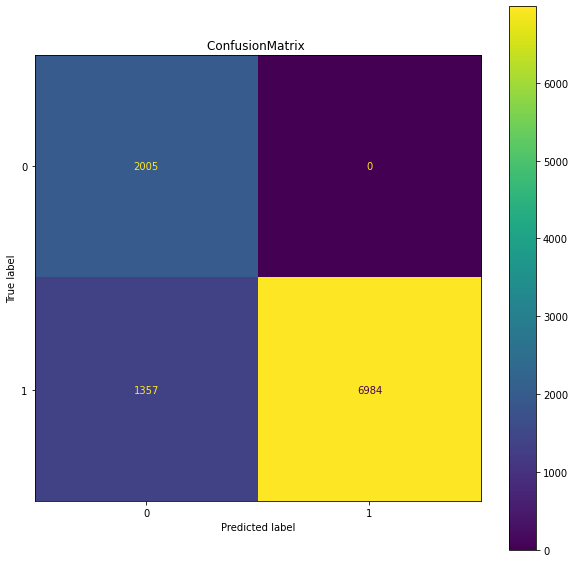

In [59]:
from collections import Counter

class Node:
    def __init__(self, ind_col, val_col, class_num, end = True):
        self.ind_col = ind_col
        self.val = val_col
        self.class_num = class_num
        self.end = end
        self.l = None
        self.r = None
    def Get_Class(self):
        return self.class_num


class Tree:
    def __init__(self, max_depth, col_indexes = [], min_node_len = 1):
        self.max_depth = max_depth
        self.col_indexes = col_indexes
        self.min_len = min_node_len
    
    def fit(self, data, labels):
        d = data.to_numpy()
        l = labels.to_numpy()

        if len(self.col_indexes) == 0:
            self.col_indexes = np.arange(len(d[0]))

        self.nodes = dict()
        ind = self.Build_Nodes(d, l, 0, 0, -1)
        
    def Get_Index_and_Val(self, data, labels):
        d_T = data.T
        lbl = labels

        rez_ind = -1
        rez_val = -1

        score = -1

        h_g_ind = self.Gini_index(lbl)
        for i in self.col_indexes:
            d = d_T[i]
            for el in d:
                l, r = self.Split_for_gini(d, lbl, el)
                l_g_ind = self.Gini_index(l)
                r_g_ind = self.Gini_index(r)

                gini_gain = h_g_ind - l_g_ind * len(l)/len(d) - r_g_ind * len(r)/len(d)

                if gini_gain > score:
                    score = gini_gain
                    rez_ind = i
                    rez_val = el
        return rez_ind, rez_val

    def Gini_index(self, labels):
        mc_lab = Counter(labels).most_common()
        rez = 0
        for (val, count) in mc_lab:
            rez += (count/len(labels))**2
        return 1 - rez

    def Split_for_gini(self, data, labels, val):
        l, r = [], []
        for i in range(len(data)):
            if (data[i] < val): l.append(labels[i])
            else: r.append(labels[i])
        return l, r

    def Split(self, data, labels, ind_col, val_col):
        l_data, l_labels, r_data, r_labels = [], [], [], []

        for i, d in enumerate(data):
            if d[ind_col] > val_col:
                r_data.append(d)
                r_labels.append(labels[i])
            else:
                l_data.append(d)
                l_labels.append(labels[i])
        
        return np.array(l_data), np.array(l_labels), np.array(r_data), np.array(r_labels)
    
    def Get_class(self, l_labels, r_labels):
        l_class, r_class = None, None

        l_vals = Counter(l_labels).most_common()
        r_vals = Counter(r_labels).most_common()

        if (l_vals[0][0] != r_vals[0][0]):
            l_class = l_vals[0][0]
            r_class = r_vals[0][0]
        elif l_vals[0][1] > r_vals[0][1]:
            l_class = l_vals[0][0]
            r_class = 1 - l_class
        else:
            r_class = r_vals[0][0]
            l_class = 1 - r_class
            

        return l_class, r_class

    def Build_Nodes(self, data, labels, num, depth, class_num):

        ind_col, val_col = self.Get_Index_and_Val(data, labels)

        # print('ind_col, val_col  - ', ind_col, val_col)

        l_data, l_labels, r_data, r_labels = self.Split(data, labels, ind_col, val_col)

        node_num = num
        node = Node(ind_col, val_col, class_num)
        self.nodes[node_num] = node

        # print('node_num: ', node_num)
        # print('len l:', len(l_labels))
        # print('len r:', len(r_labels))

        if len(l_labels) <= self.min_len or len(r_labels) <= self.min_len or depth >= self.max_depth:
            return node_num
        else:
            self.nodes[node_num].end = False
        
        l_class, r_class = self.Get_class(l_labels, r_labels)

        # left
        left_node_num = node_num + 1
        self.nodes[node_num].l = left_node_num

        temp_node_num = self.Build_Nodes(l_data, l_labels, left_node_num, depth + 1, l_class)

        # right
        right_node_num = temp_node_num + 1
        self.nodes[node_num].r = right_node_num

        temp_node_num = self.Build_Nodes(r_data, r_labels, right_node_num, depth + 1, r_class)

        return temp_node_num


    def predict(self, data):
        d = data.to_numpy()
        ans = []

        for str in d:
            a = self.Find(str, 0)
            ans.append(a)
        return ans

    def Find(self, str, ind):
        if self.nodes[ind].end == True:
            return self.nodes[ind].class_num
        elif str[self.nodes[ind].ind_col] < self.nodes[ind].val:
            return self.Find(str, self.nodes[ind].l)
        else:
            return self.Find(str, self.nodes[ind].r)

    def Print(self, ind):
        if self.nodes[ind].end == True:
            print(ind, 'end')
        else:
            print(ind, ' l: ', self.nodes[ind].l, ' r: ', self.nodes[ind].r)
            self.Print(self.nodes[ind].l)
            self.Print(self.nodes[ind].r)

tr = Tree(3)
tr.fit(data_train[:2000], label_train[:2000])

pr = tr.predict(data_test)

print("Точность:", (pr == label_test).mean())

plot_ConfusionMatrix(label_test, pr)

Так как реализованный мной алгоритм при делении на узле дерева предпологает проход по всем данным и по всем значениям для оценки наилучшего разбиения, то с большим количеством входных значений дерево строится очень долго. Поэтому было решено построить дерево на первых двух тысячах данных. Анализируя результаты можно увидеть, что алгоритм показал неплохую точность.

### Случайный лес

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rnf = RandomForestClassifier();
rnf.fit(data_train, label_train)

RandomForestClassifier()

Точность: 0.9999033442876474


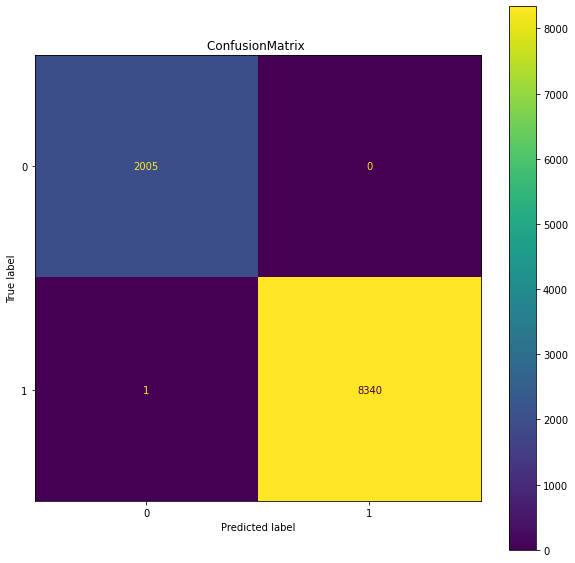

In [55]:
pr = rnf.predict(data_test)

test_accuracy_score = rnf.score(data_test, label_test)
print("Точность:", test_accuracy_score)

plot_ConfusionMatrix(label_test, pr)

Анализируя матрицу ошибок и точность можно сделать вывод о том, что ансамбль Случайный лес почти безошибочно предсказал значения для данной тестовой выборки  